# How to Easily Perform Outlier Detection In Python For Machine Learning, #2
## Earth is an outlier - the code, part 2
![](images/pixabay.jpg)
<figcaption style="text-align: center;">
    Image by <a href="https://pixabay.com/users/alexas_fotos-686414/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=1744091">Alexa</a> from <a href="https://pixabay.com//?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=1744091">Pixabay</a>
</figcaption>

### Introduction

The first question to ask before starting outlier detection is "Does my dataset even have outliers?". While the usual answer is "Yes", it is always recommended to sniff the hint of outlier presence in the air before making big efforts (like using machine learning models) to isolate them.

So, we will start off this second part of our outlier detection tutorial series by looking at general methods of detecting the presence of outliers like data visualization. Then, we will continue the post by talking about methods to detect both univariate and multivaraite outliers.
 
Let's get started!

### The dataset to be used

We'll be using the Diamonds dataset throughout the tutorial. It is large enough for it to not be a toy dataset and it has got a nice combination of numeric and categorical features. 

In [235]:
import seaborn as sns

diamonds = sns.load_dataset("diamonds")

Our eventual task after outlier detection is predicting the carat of diamonds given its physical characteristics and price:

In [236]:
diamonds.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

So, let's extract the feature and target arrays and encode the categorical columns using OrdinalEncoder class from Sklearn:

In [237]:
from sklearn.preprocessing import OrdinalEncoder

# Extract feature and target arrays
X, y = diamonds.drop("carat", axis=1), diamonds["carat"]
# Select categorical column names
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Encode categoricals
X.loc[:, cats] = OrdinalEncoder().fit_transform(X[cats])

Now, we are ready.

### Do outliers even exist?

In [74]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [75]:
y.describe()

count    53940.000000
mean         0.797940
std          0.474011
min          0.200000
25%          0.400000
50%          0.700000
75%          1.040000
max          5.010000
Name: carat, dtype: float64

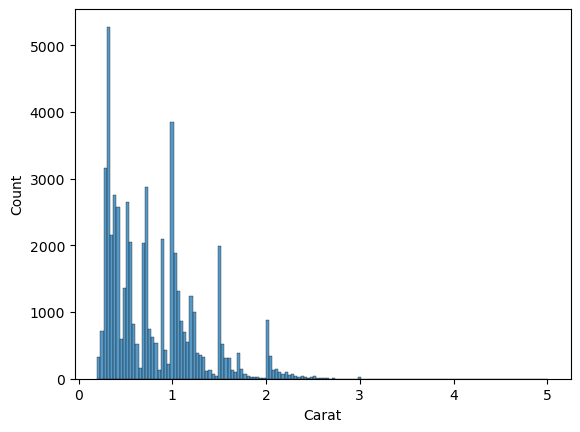

In [76]:
sns.histplot(y)

plt.xlabel("Carat");

In [77]:
X.drop(cats, axis=1).describe()

,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


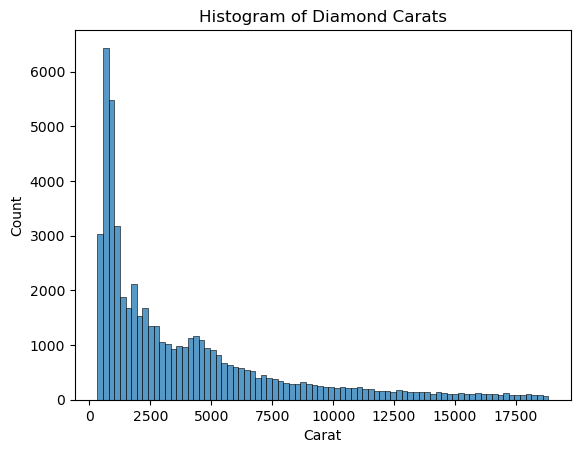

In [78]:
sns.histplot(X["price"])

plt.title("Histogram of Diamond Carats")
plt.xlabel("Carat");

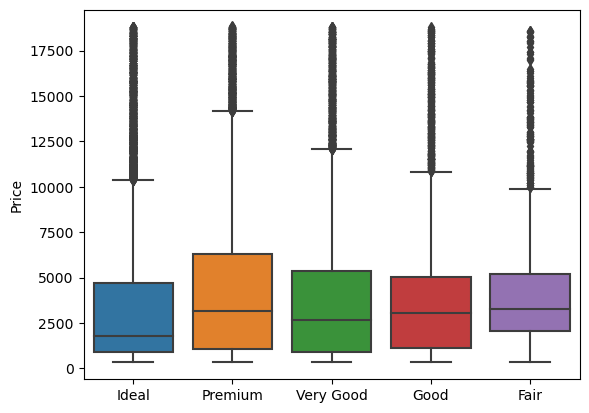

In [79]:
sns.boxplot(x="cut", y="price", data=diamonds, whis=1.5)

plt.xlabel("")
plt.ylabel("Price");

### Univariate outlier detection

In [84]:
from scipy.stats import zscore

is_outlier = zscore(y).abs() > 3
outliers_y = y[is_outlier]

num_outliers = len(outliers_y)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(y):.2f}")

The number of outliers: 439
Percentage of outliers: 0.01


It is the standard deviation but with the median at the core.

In [85]:
from scipy.stats import median_abs_deviation

median_abs_deviation(y)

0.32000000000000006

### Modified z-scores

Now, if we use the MAD score in z-scores formula, it becomes modified z-scores:

In [206]:
from pyod.models.mad import MAD

mad = MAD().fit(y.values.reshape(-1, 1))

labels = pd.Series(mad.labels_)
labels.sample(5)

40985    0
32491    0
51989    0
49503    0
6988     0
dtype: int64

In [209]:
outliers_y_mad = y[labels == 1]

num_outliers = len(outliers_y_mad)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(y):.3f}")

The number of outliers: 222
Percentage of outliers: 0.004


### Multivariate outlier detection with PyOD

In [211]:
from pyod.models.lof import LOF

lof = LOF(n_neighbors=30).fit(X)

labels = pd.Series(lof.labels_)
outliers_X_lof = X[labels == 1]

num_outliers = len(outliers_X_lof)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(X):.3f}")

The number of outliers: 5394
Percentage of outliers: 0.100


In [214]:
from pyod.models.iforest import IForest

iforest = IForest(n_estimators=500).fit(X)

labels = pd.Series(iforest.labels_)
outliers_X_iforest = X[labels == 1]

num_outliers = len(outliers_X_iforest)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(X):.3f}")

The number of outliers: 5394
Percentage of outliers: 0.100


### Contamination

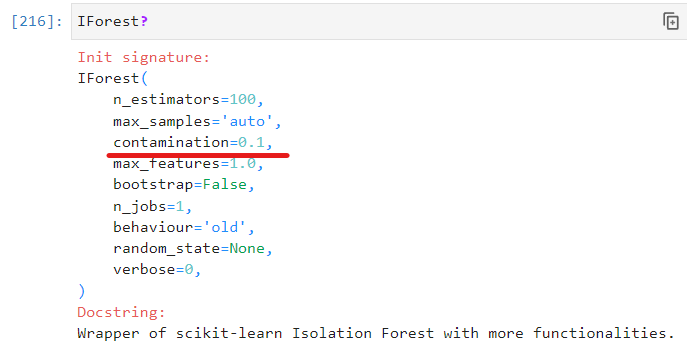

In [217]:
iforest = IForest().fit(X)

iforest.decision_scores_[:10]

array([-0.01789882,  0.03646687,  0.09759012, -0.06977119, -0.02610138,
        0.01991868,  0.00180873, -0.00440727,  0.08668909,  0.04439745])

In [218]:
from pyod.models.knn import KNN

knn = KNN().fit(X)

knn.decision_scores_[:10]

array([11.56034602, 12.46189392, 13.42818305,  6.09343909,  5.39804594,
        5.90354978,  5.12414871,  5.41214375,  8.1313775 ,  6.87590721])

### Probability scores

In [227]:
from pyod.models.iforest import IForest

iforest = IForest(n_estimators=1000).fit(X)

probs = iforest.predict_proba(X)
probs[:10]

array([[0.6595839 , 0.3404161 ],
       [0.49970223, 0.50029777],
       [0.30612256, 0.69387744],
       [0.73151238, 0.26848762],
       [0.58695384, 0.41304616],
       [0.42048955, 0.57951045],
       [0.53045075, 0.46954925],
       [0.6171362 , 0.3828638 ],
       [0.33290998, 0.66709002],
       [0.46752207, 0.53247793]])

In [230]:
threshold = 0.9

is_outlier = probs[:, 1] > threshold
outliers_X_probs = X[is_outlier]

num_outliers = len(outliers_X_probs)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(X):.4f}")

The number of outliers: 10
Percentage of outliers: 0.0002


### Conclusion